In [3]:
# !pip install logomaker

In [4]:
import logomaker as lm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from src.utils.utils import get_hyperparameters
from src.models.model35 import nn_model

ROOT_DIR = "../"

model_weights_file = ROOT_DIR + "model_weights/model35_parameters_parameter_274"
parameter_file = ROOT_DIR + "hyperparameters/parameter.txt"
params = get_hyperparameters(parameter_file)

nn = nn_model(hyperparameters=params)
model = nn.create_model()

model.load_weights(model_weights_file)

np.set_printoptions(threshold=sys.maxsize, precision=5, suppress=True)

museum_layer_num = 2
museum_layer = model.layers[museum_layer_num]
_, ic_scaled_prob = museum_layer.get_motifs()

motifs = np.array(ic_scaled_prob)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 forward (InputLayer)           [(None, 50, 4)]      0           []                               
                                                                                                  
 reverse (InputLayer)           [(None, 50, 4)]      0           []                               
                                                                                                  
 multinomial_convolution_layer_  (None, 50, 256)     8448        ['forward[0][0]',                
 1 (MultinomialConvolutionLayer                                   'reverse[0][0]']                
 )                                                                                                
                                                                                            

2022-07-02 10:50:06.872430: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../model_weights/model35_parameters_parameter_274: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [7]:
def show_motif(motif_matrix, output_filepath=None):
    df = pd.DataFrame(motif_matrix, columns=['A', 'C', 'G', 'T'])
    print(df.head())
    logo = lm.Logo(df, 
                   font_name='Arial Rounded MT Bold', 
                   color_scheme={'A': 'tab:red', 'C': 'blue', 'G': 'goldenrod', 'T': 'green'},
                       
    )
    logo.ax.set_ylim((0, 2.85))
    logo.baseline_width = 2.0
    logo.style_spines(spines=['top', 'right'], visible=False)
    # logo.ax.spines['bottom'].set_bounds((0, 7))
    logo.ax.spines['left'].set_bounds((0, 2))
    logo.style_spines(spines=['bottom', 'left'], linewidth=2)
    logo.ax.xaxis.set_tick_params(width=2)
    logo.ax.yaxis.set_tick_params(width=2)

    logo.ax.set_yticks([0, 2])
    logo.ax.set_yticklabels(['0', '2'], fontsize=40)
    logo.ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8'], fontsize=40)
    logo.ax.set_xlabel('Position', fontsize=32)
    logo.ax.set_ylabel('Information\nContent (bits)', fontsize=32)
    logo.ax.yaxis.set_label_coords(-0.08, 0.4)

    plt.gcf().set_size_inches(8, 5)

    if output_filepath:
      plt.savefig(output_filepath, format='svg')

    plt.show()

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


          A         C         G         T
0  0.338684  0.037514  0.093885  0.036547
1  1.241372  0.000510  0.122457  0.000363
2  1.720423  0.000086  0.000924  0.004850
3  0.089544  0.030954  0.008796  0.072854
4  0.014964  0.018173  0.014414  0.036294


/tmp/ipykernel_13077/3518024393.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  logo.ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8'], fontsize=40)


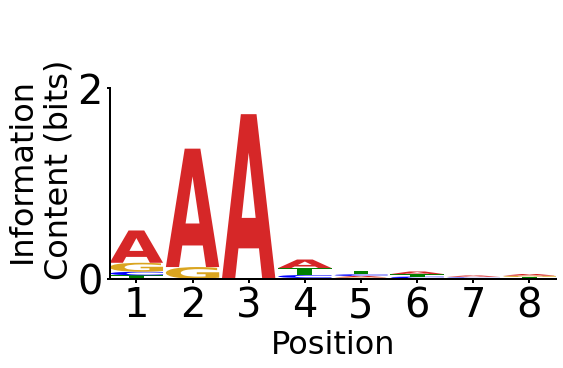

In [8]:
motif_num = 190

show_motif(motifs[motif_num])

In [9]:
import tensorflow as tf

def plot_conv_positional_weight(filter_num, prev_filter_num, out_path=None):
    layer_num = 5
    weights_tf = tf.transpose(model.layers[layer_num].get_weights()[0], [2, 0, 1])
    weights = np.array(weights_tf[filter_num])
    pos_weights = weights[:, prev_filter_num]

    x = np.arange(pos_weights.shape[0])
    color = ['navy' if h > 0 else 'lightgray' for h in pos_weights]
    plt.bar(x, pos_weights, bottom=0,
            color=color, capsize='round', width=1)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds((0, pos_weights.shape[0]))
    ax.spines['left'].set_bounds((-.2, .2))
    ax.set_yticks([-.2, 0, .2])
    ax.set_xticks([0, 20, 40])
    ax.set_yticklabels(['-0.2', '0', '0.2'], fontsize=40)
    ax.set_xticklabels(['0', '20', '40'], fontsize=40)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    
    plt.ylim((-.2, .2))

    ax.set_xlabel('Position', fontsize=32)
    ax.set_ylabel('Relative\nImportance', fontsize=32)
    ax.yaxis.set_label_coords(-0.15, 0.5)

    plt.gcf().set_size_inches(8, 5) 

    if out_path:
        plt.savefig(out_path, format="svg")
    
    plt.show()
    plt.close()


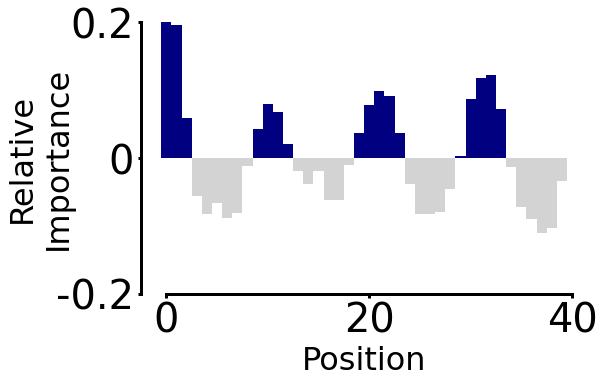

In [10]:
motif_num = 190
pos_or_neg = 0

plot_conv_positional_weight(filter_num=pos_or_neg, prev_filter_num=motif_num, out_path=None)

In [11]:
def draw_first_conv_layer(filter_num, vmin=-0.1, vmax=0.1, aspect_ratio=1, output_path=None):
    layer_num = 2
    weights_tf = tf.transpose(model.layers[layer_num].get_weights()[0], [2, 0, 1])
    weights = -np.array(weights_tf[filter_num])
    plt.imshow(weights.T, cmap='bwr',
               vmin=vmin, vmax=vmax, aspect=aspect_ratio, interpolation='nearest')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds((0, 7))
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['A', 'C', 'G', 'T'], fontsize=38)
    ax.set_xticks([0, 3, 7])
    ax.set_xticklabels(['1', '4', '8'], fontsize=40)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    
    # plt.gcf().set_size_inches(20, 10)

    if output_path:
        plt.savefig(output_path, dpi=1200, format='svg')
    plt.show()
    plt.close()


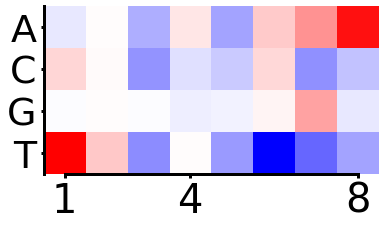

In [12]:
motif_num = 0

draw_first_conv_layer(filter_num=motif_num, output_path=None)

In [13]:
def draw_second_conv_layer(filter_num, vmin=-0.2, vmax=0.2, aspect_ratio=1, output_path=None):
    layer_num = 5
    weights_tf = tf.transpose(model.layers[layer_num].get_weights()[0], [2, 0, 1])
    weights = -np.array(weights_tf[filter_num])
    plt.imshow(weights.T, cmap='bwr',
               vmin=vmin, vmax=vmax, aspect=aspect_ratio, interpolation='nearest')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds((0, 40))
    ax.set_yticks([0, 127, 255])
    ax.set_yticklabels(['1', '128', '256'], fontsize=38)
    ax.set_xticks([0, 19, 39])
    ax.set_xticklabels(['1', '20', '40'], fontsize=40)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    
    plt.gcf().set_size_inches(50, 50) # draw with 100, 100 for figure

    if output_path:
        plt.savefig(output_path, dpi=100, format='svg')
    plt.show()
    plt.close()


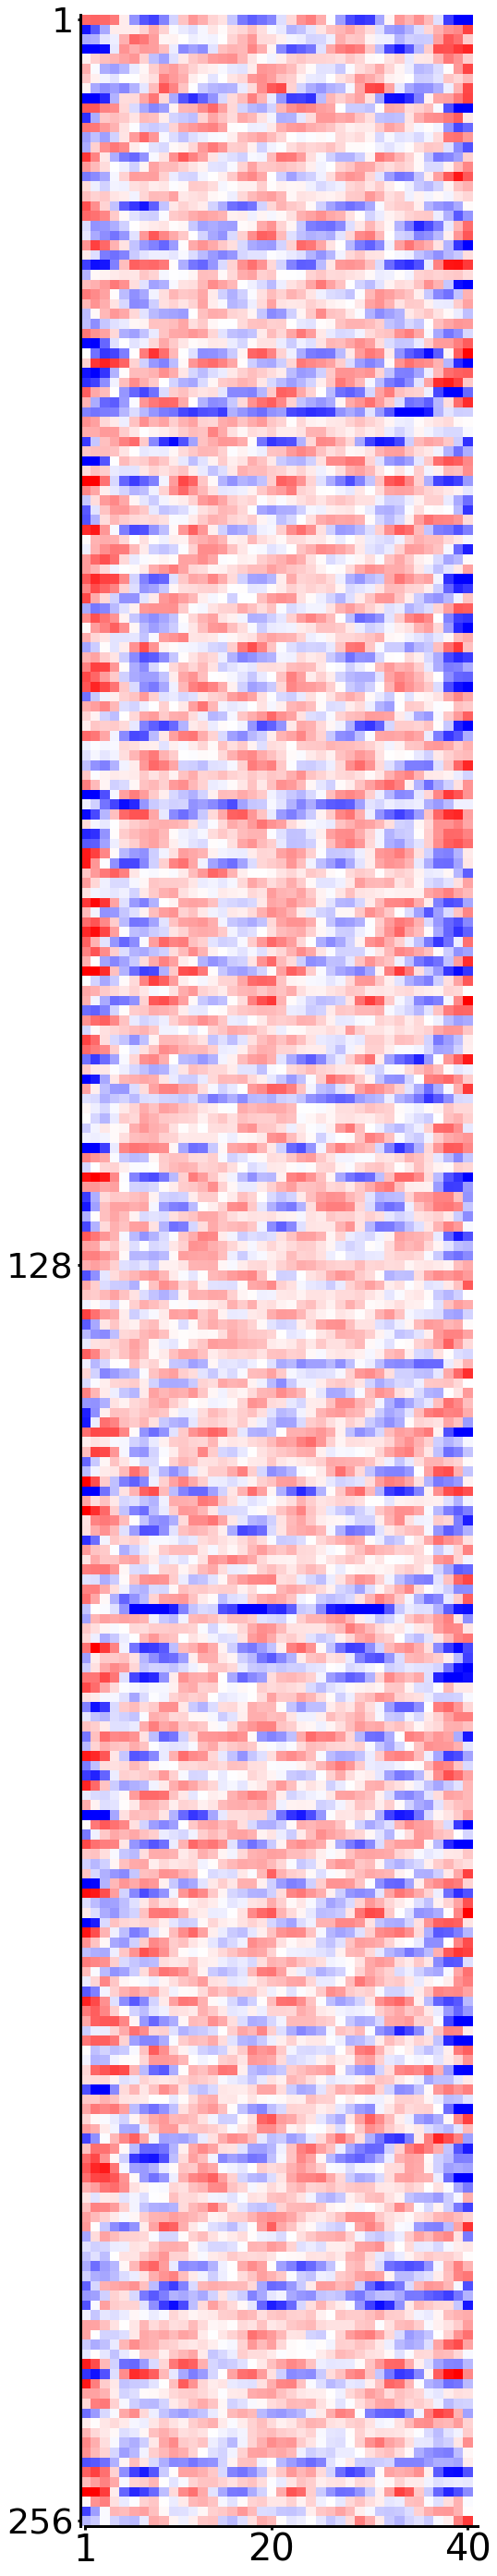

In [14]:
draw_second_conv_layer(filter_num=motif_num, output_path=None)

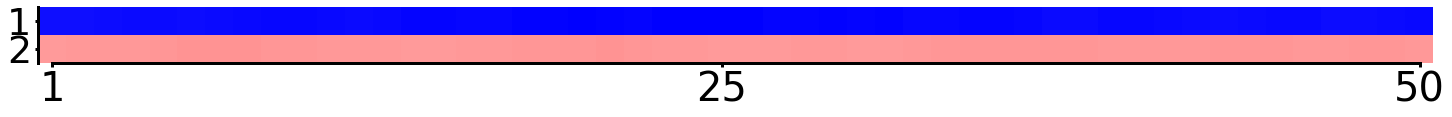

In [18]:
def draw_third_conv_layer(vmin=-0.2, vmax=0.2, aspect_ratio=1, output_path=None):
    layer_num = 8
    filter_num = 0
    weights_tf = tf.transpose(model.layers[layer_num].get_weights()[0], [2, 0, 1])
    weights = -np.array(weights_tf[filter_num])
    plt.imshow(weights.T, cmap='bwr',
               vmin=vmin, vmax=vmax, aspect=aspect_ratio, interpolation='nearest')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds((0, 49))
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['1', '2'], fontsize=38)
    ax.set_xticks([0, 24, 49])
    ax.set_xticklabels(['1', '25', '50'], fontsize=40)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    
    plt.gcf().set_size_inches(25, 25)

    if output_path:
        plt.savefig(output_path, dpi=100, format='svg')
    plt.show()
    plt.close()

draw_third_conv_layer()

In [19]:
from src.utils.data_preprocess import preprocess

data_file = ROOT_DIR + "data/chrV.txt"
prep = preprocess(data_file)

data = prep.get_one_hot_encoded_dataset()

x1 = data["forward"]
x2 = data["reverse"]
y = data["readout"]


In [20]:
from keras import Model

In [21]:
def draw_input(x1, x2, input_num=0, vmin=-0.2, vmax=0.2, aspect_ratio=1, output_path=None):
    layer_num = 0
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_num].output)
    intermediate_output = np.array(intermediate_layer_model({'forward': x1, 'reverse': x2})[input_num])

    plt.imshow(intermediate_output.T, cmap='Blues',
               vmin=vmin, vmax=vmax, aspect=aspect_ratio)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds((0, 50))
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['A', 'C', 'G', 'T'], fontsize=30)
    ax.set_xticks([0, 9, 19, 29, 39, 49])
    ax.set_xticklabels(['1', '10', '20', '30', '40', '50'], fontsize=40)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    
    plt.gcf().set_size_inches(20, 10)

    if output_path:
        plt.savefig(output_path, dpi=1200, format='svg')
    plt.show()
    plt.close()


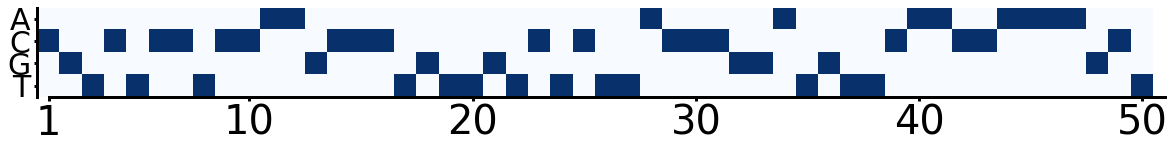

In [22]:
seq_num = 0

draw_input(x1[:100], x2[:100], input_num=seq_num, vmin=0, aspect_ratio=1, output_path=None)

In [23]:
def draw_conv_layer_output(x1, x2, input_num=0, vmin=-.1, vmax=.1, aspect_ratio=1, output_path=None):
    layer_num = 3
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_num].output)
    intermediate_output = np.array(intermediate_layer_model({'forward': x1, 'reverse': x2})[input_num])

    plt.imshow(-intermediate_output.T, cmap='bwr',
               vmin=vmin, vmax=vmax, aspect=aspect_ratio, interpolation='nearest')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_bounds((0, 50))
    ax.set_yticks([0, 127, 255])
    ax.set_yticklabels(['1', '128', '256'], fontsize=40)
    ax.set_xticks([0, 9, 19, 29, 39, 49])
    ax.set_xticklabels(['1', '10', '20', '30', '40', '50'], fontsize=40)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    
    plt.gcf().set_size_inches(50, 50) # 100, 100 for figure

    if output_path:
        plt.savefig(output_path, dpi=100, format='svg')
    plt.show()
    plt.close()


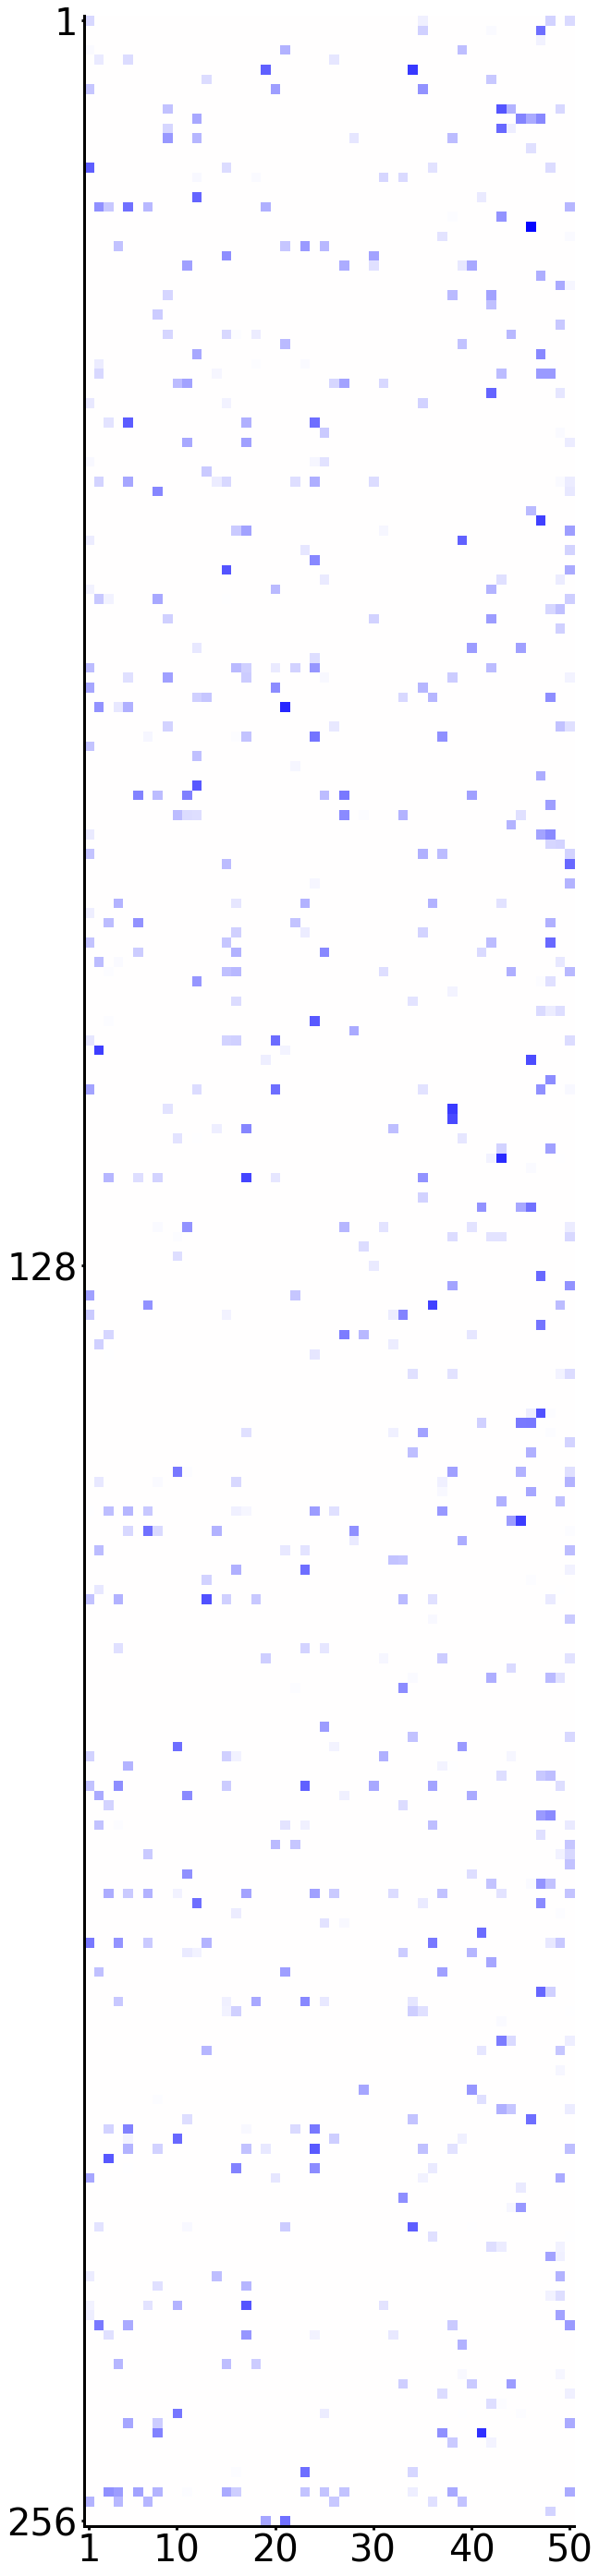

In [24]:
seq_num = 0

draw_conv_layer_output(x1[:10], x2[:10], seq_num, output_path=None)

In [25]:
def draw_last_conv_layer_output(x1, x2, input_num, vmin=-.25, vmax=.25, aspect_ratio=1, output_path=None):
    layer_num = 5
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_num].output)
    intermediate_output = np.array(intermediate_layer_model({'forward': x1, 'reverse': x2})[input_num]).clip(min=0)

    # print(intermediate_output)

    plt.imshow(-intermediate_output.T, cmap='bwr',
               vmin=vmin, vmax=vmax, aspect=aspect_ratio, interpolation='nearest')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_bounds((0, 50))
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['1', '2'], fontsize=28)
    ax.set_xticks([0, 9, 19, 29, 39, 49])
    ax.set_xticklabels(['1', '10', '20', '30', '40', '50'], fontsize=40)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=3)
    
    plt.gcf().set_size_inches(20, 10)

    # sns.heatmap(-intermediate_output.T, cmap='bwr', vmin=vmin, vmax=vmax, square=True,
    #         linewidths=.5, cbar=False)

    if output_path:
        plt.savefig(output_path, dpi=200, format='svg')
    plt.show()
    plt.close()


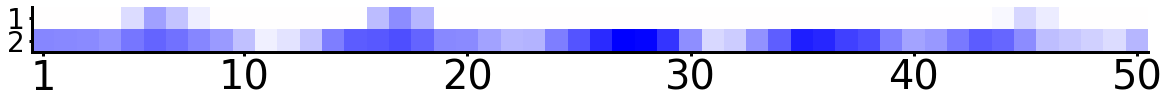

In [26]:
draw_last_conv_layer_output(x1[:10], x2[:10], seq_num, output_path=None)

In [27]:
def get_intermediate_output(x1, x2, input_num, layer_num, node):

  intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[layer_num].get_output_at(node))

  intermediate_output = intermediate_layer_model({'forward': x1, 'reverse': x2})[input_num]

  return intermediate_output

In [28]:
def get_layer_weights(layer_num, kernel_num):
  weights_tf = tf.transpose(model.layers[layer_num].get_weights()[0], [2, 0, 1])
  weights = np.array(weights_tf[kernel_num])
  return weights 

In [29]:
seq_num = 4829

In [30]:
inter_out = get_intermediate_output(x1[:5000], x2[:5000], seq_num, 5, 0)

2022-07-02 10:52:15.915744: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.
2022-07-02 10:52:15.969602: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.


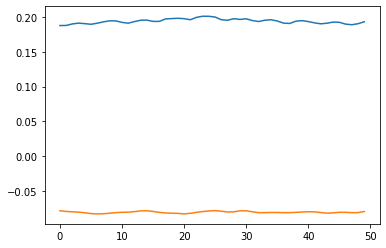

In [31]:
layer_8_0 = get_layer_weights(8, 0)
w = layer_8_0
plt.plot(w)

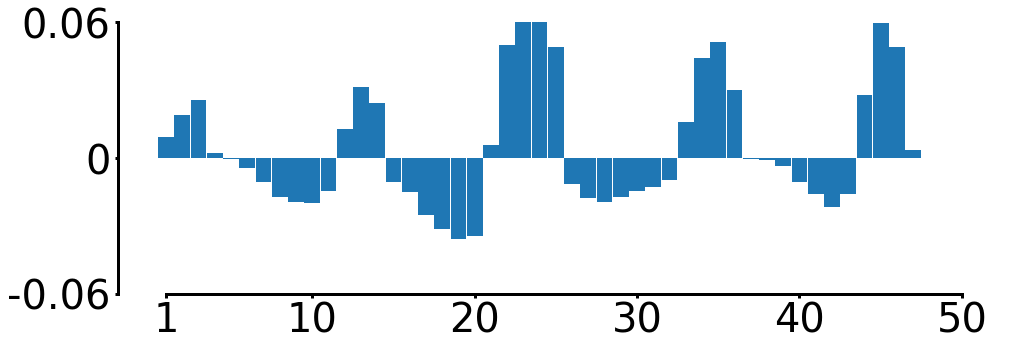

In [32]:
pos = np.mean(w[:, 0]) * np.maximum(inter_out[:, 0], 0)
neg = np.mean(w[:, 1]) * np.maximum(inter_out[:, 1], 0)
sum = pos+neg
plt.bar(np.arange(sum.shape[0]), sum, width=0.97)

hi = .06
lo = -.06

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds((0, 49))
ax.spines['left'].set_bounds((lo, hi))
ax.set_yticks([lo, 0, hi])
ax.set_xticks([0, 9, 19, 29, 39, 49])
ax.set_yticklabels([str(lo), '0', str(hi)], fontsize=40)
ax.set_xticklabels(['1', '10', '20', '30', '40', '50'], fontsize=40)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

plt.ylim((lo, hi))

plt.gcf().set_size_inches(16, 5)
# plt.savefig('out1.svg', format='svg')

In [33]:
w_m = get_layer_weights(5, 0)
# print(w_m.shape)

In [34]:
out_2 = get_intermediate_output(x1[:5000], x2[:5000], seq_num, 2, 0)
print(out_2.shape)

(50, 256)


2022-07-02 10:52:18.974015: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256000000 exceeds 10% of free system memory.


0 -0.19203651607908223
1 -0.25369972641239286
2 -0.24963896224760526
3 -0.15576292969249256
4 -0.04568379197809002
5 0.051235584209671094
6 0.11561776574989079
7 0.14860909091840618
8 0.15660166525507274
9 0.01996548484082468
10 -0.15005603577630094
11 -0.3295344555574491
12 -0.4400857389596304
13 -0.3561287784008915
14 -0.24854084398556545
15 -0.1305303710180128
16 0.014079941004605608
17 0.14209324163614495
18 0.22063713512569738
19 0.17824042385877623
20 -0.011265292388639395
21 -0.3256576622329145
22 -0.5707691789298506
23 -0.5936191680821432
24 -0.4439273027038094
25 -0.17292105921907275
26 0.1527976322600992
27 0.35659203339862144
28 0.5348054110771323
29 0.5014968195010104
30 0.29951902619495113
31 -0.015101699986590195
32 -0.27984333481741236
33 -0.36916307044244423
34 -0.36244302812475515
35 -0.32553559974588747
36 -0.23782979268424687
37 -0.08259494479746654
38 0.11937633716875509
39 0.2651933632016058
40 0.3003852609278857
41 0.17462209293429387
42 -0.06827354336384797
43 -0

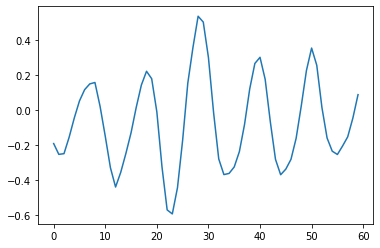

In [35]:
padded_out_2 = np.zeros((100, 256))
padded_out_2[25:-25] = out_2

convs = []

for off in range(60):
  conv = np.sum(np.multiply(np.maximum(padded_out_2[off:40+off], 0), w_m))
  convs.append(conv)
  print(f"{off} {conv}")

plt.plot(convs)

In [36]:
off = np.argmax(convs)
print(f"maximum signal at offset: {off}")
conv = np.multiply(np.maximum(padded_out_2[off:40+off], 0), w_m)
conv_sum = np.sum(conv, axis=0)
sorted_presence = np.argsort(conv_sum)[::-1]
print(sorted_presence)

maximum signal at offset: 28
[150 190  36 183  83 144   1 169 143  24 101  52 179 142 213 209  25 201
  68 128  51  97 121  35  57   8 191  62 148  27 252 204  10  76  60 254
 184  93 149  85 177 220 167  94 152  50  49  87 106 133 203 244 159 239
 108 237  84   9 192 240  69 117 230  32 206  92   2  65  13 207   0  66
  64  91  43 180  61  26  39  31 168 202  73 232  95  96 129 234 102  90
 146 173 223  58 195 100 227  86 166  98 116 255 135  70 210  48 193 226
 228 187 186 229  99  45  53 178  42 104  41 176 107 175  40 194 197 214
 222 217 218 211  74  75 219  77  79  89  80  82  56 205 199  54  88 110
 111  38 162 113  19 136  17  11 248 141 249 131 250 158 147 157   5 155
   3  20 163 130 164 114  34  33 172 118  30 120 171 122  29 124 245 246
  21 165 224  55 212 161 137 127 253 139 174 236 112 196  72  59 138 109
 185 126 151 251  44  67  71 215 145 134 238 231   4  63 132 119  18   6
  16 200 156  15 115 182 153 221  47 242 233  23 235 243 189  12  28 170
  46 160  14 103 125 1

150


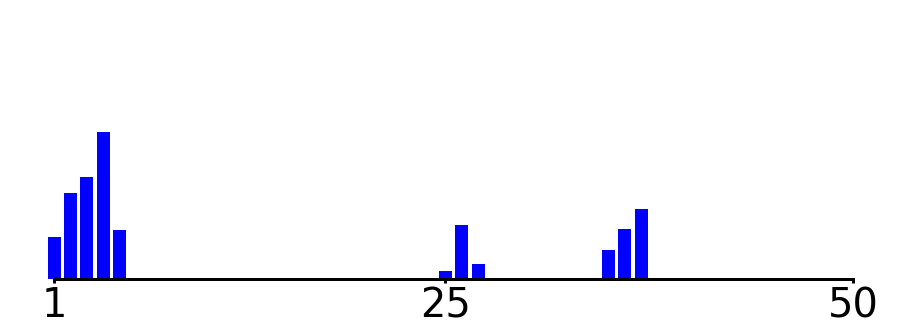

190


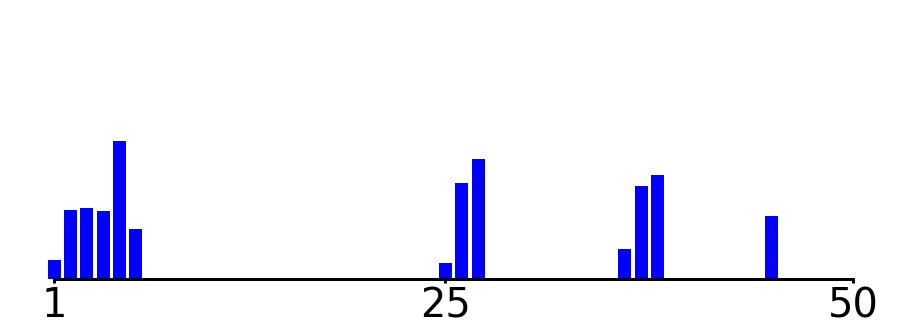

36


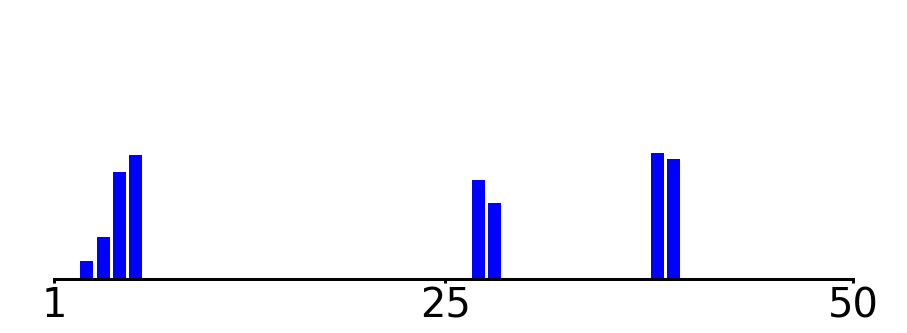

183


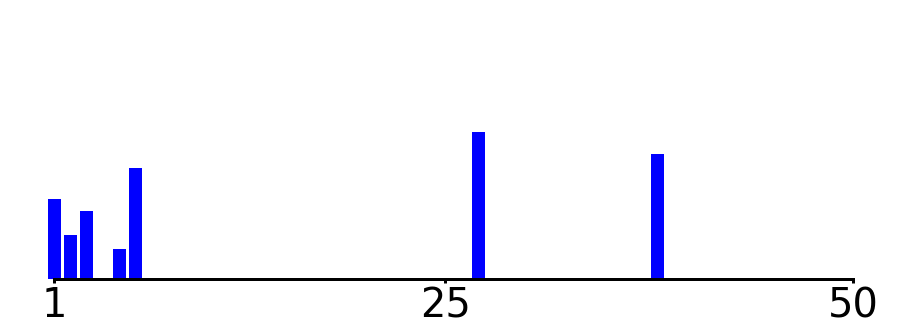

83


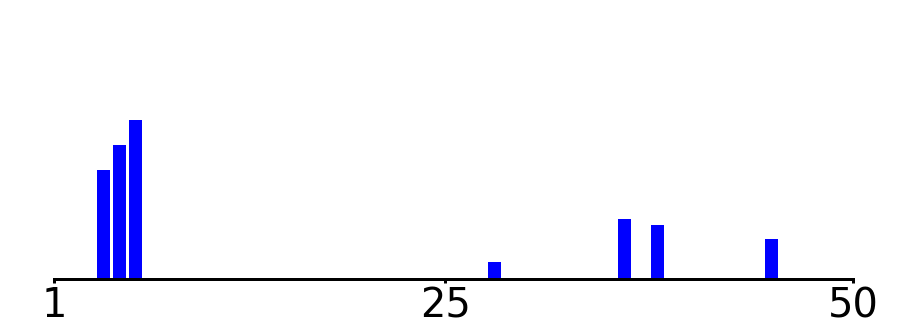

In [37]:
show_top = 5
top_sorted_presence = sorted_presence[:show_top]
hi = .1
lo = 0
show_left_bar = False

for matching_score in top_sorted_presence:
  plt.bar(np.arange(50), np.maximum(out_2[:, matching_score], 0), color='blue')

  ax = plt.gca()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_bounds((0, 49))
  if show_left_bar:
    ax.spines['left'].set_bounds((lo, hi))
    ax.set_yticks([lo, hi])
    ax.set_yticklabels([str(lo), str(hi)], fontsize=40)
  else:
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
  ax.set_xticks([0, 24, 49])
  ax.set_xticklabels(['1', '25', '50'], fontsize=40)
  ax.spines['bottom'].set_linewidth(3)
  ax.spines['left'].set_linewidth(3)
  ax.xaxis.set_tick_params(width=3)
  ax.yaxis.set_tick_params(width=3)

  plt.ylim((lo, hi))

  plt.gcf().set_size_inches(16, 5) 

  # plt.savefig(f'motif_{motif}.svg', format='svg')
  print(matching_score)
  plt.show()
  # plt.savefig(f"motif_{motif}.svg", format='svg')
  # plt.close()

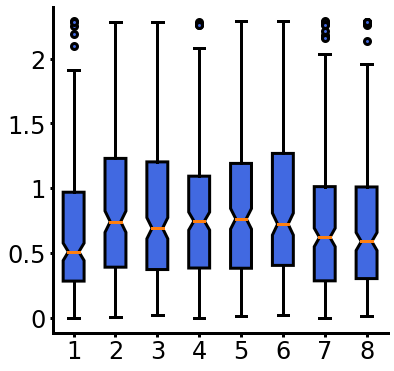

In [38]:
ic = np.sum(motifs, axis=2)
ic_sorted = np.flip(np.sort(ic, axis=1), axis=1)
# plt.plot(np.mean(ic_sorted, axis=0))
ax = plt.gca()

plt.boxplot(ic, 
            patch_artist=True, 
            notch=True, 
            boxprops=dict(facecolor='royalblue', linewidth=3), 
            medianprops=dict(linewidth=3),
            whiskerprops=dict(linewidth=3),
            capprops=dict(linewidth=3),
            flierprops=dict(markerfacecolor='royalblue', markeredgewidth=3)
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xticks(xticks)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8'], fontsize=24)
yticks = [0, .5, 1, 1.5, 2]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=24)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

plt.gcf().set_size_inches(6, 6)
# plt.savefig('boxplot.svg', format='svg')
# plt.show()

In [39]:
def get_com(motif):
  ic = np.sum(motif, axis=1)
  num = 0
  den = 0
  for i, h in enumerate(ic):
    num += i * h
    den += h
  com = num / den
  return com

In [40]:
centred_motif_array = np.zeros((motifs.shape[0], 2*motifs.shape[1], motifs.shape[2]))
for i, motif in enumerate(motifs):
  off = 8 - int(round(get_com(motif))) - 1
  centred_motif_array[i][off:off+motifs.shape[1]] = motif

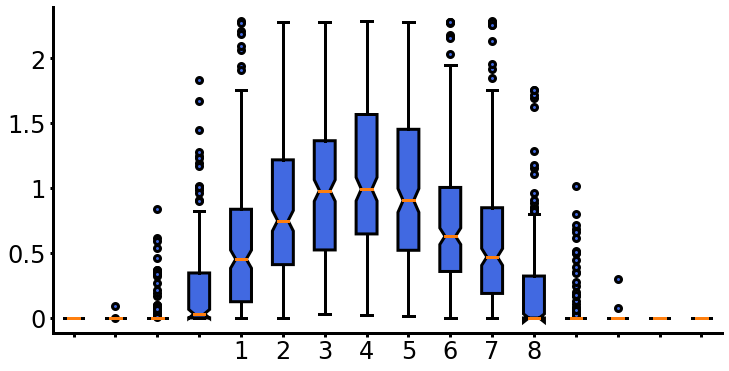

In [42]:
ic = np.sum(centred_motif_array, axis=2)
ic_sorted = np.flip(np.sort(ic, axis=1), axis=1)
# plt.plot(np.mean(ic_sorted, axis=0))
ax = plt.gca()

plt.boxplot(ic, 
            patch_artist=True, 
            notch=True, 
            boxprops=dict(facecolor='royalblue', linewidth=3), 
            medianprops=dict(linewidth=3),
            whiskerprops=dict(linewidth=3),
            capprops=dict(linewidth=3),
            flierprops=dict(markerfacecolor='royalblue', markeredgewidth=3)
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xticks(xticks)
ax.set_xticklabels(['', '', '', '', '1', '2', '3', '4', '5', '6', '7', '8', '', '', '', ''], fontsize=24)
yticks = [0, .5, 1, 1.5, 2]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks], fontsize=24)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

plt.gcf().set_size_inches(12, 6)
# plt.savefig('boxplot.svg', format='svg')
plt.show()